In [2]:
import os
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, min, max, mean, when, count, sum, split, countDistinct, unix_timestamp, lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, DoubleType, TimestampType, FloatType
from pyspark.sql.window import Window
from pyspark.sql.functions import year, month, dayofmonth, hour, datediff
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import datetime
from pyspark.ml.evaluation import ClusteringEvaluator
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
from pyspark.ml.clustering import KMeansModel

/home/amine/.local/lib/python3.10/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("user_session", StringType(), True)
])

spark = SparkSession.builder \
    .appName("msprv3") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.cores", "6") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/25 20:58:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/25 20:58:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [57]:
from pyspark.sql import functions as F

# Filtrer les événements de type "purchase"
purchases_df = combined_df.filter(combined_df.event_type == "purchase")

# Ajouter une colonne avec le mois de l'événement
purchases_df = purchases_df.withColumn("month", F.date_format(purchases_df.event_time, "yyyy-MM"))

# Calculer la somme des prix pour chaque session utilisateur par mois
session_total_df = purchases_df.groupBy("month", "user_session").agg(F.sum("price").alias("session_total"))

# Calculer le panier moyen pour chaque mois
monthly_average_basket_value = session_total_df.groupBy("month").agg(F.avg("session_total").alias("average_basket_value"))

# Afficher les résultats
monthly_average_basket_value.show()


+-------+--------------------+
|  month|average_basket_value|
+-------+--------------------+
|2019-10|   365.2544857819142|
|2020-02|  375.37292252210574|
|2019-11|   345.4194140470352|
|2020-05|   419.1569216417911|
|2020-03|   384.7077046979165|
|2020-01|   371.4240602975602|
|2019-12|     354.83779892284|
|2020-04|   285.6421997645362|
+-------+--------------------+



In [4]:
octobre_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2019-Oct.csv", header=False, schema=schema)
novembre_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2019-Nov.csv", header=False, schema=schema)
decembre_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2019-Dec.csv", header=False, schema=schema)
janvier_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Jan.csv", header=False, schema=schema)
fevrier_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Feb.csv", header=False, schema=schema)
mars_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Mar.csv", header=False, schema=schema)
avril_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Apr.csv", header=False, schema=schema)

combined_df = (octobre_df
               .union(novembre_df)
               .union(decembre_df)
               .union(janvier_df)
               .union(fevrier_df)
               .union(mars_df)
               .union(avril_df))

In [5]:
from pyspark.sql import functions as F

# Calculer les features de base

# Nombre total d'achats par client
total_purchases = combined_df.filter(combined_df.event_type == 'purchase') \
                             .groupBy("user_id") \
                             .agg(F.count("event_type").alias("total_purchases"))

# Valeur totale des achats par client
total_spent = combined_df.filter(combined_df.event_type == 'purchase') \
                         .groupBy("user_id") \
                         .agg(F.sum("price").alias("total_spent"))

# Valeur moyenne des achats par client
avg_spent = combined_df.filter(combined_df.event_type == 'purchase') \
                       .groupBy("user_id") \
                       .agg(F.avg("price").alias("avg_spent"))

# Valeur maximale des achats par client
max_spent = combined_df.filter(combined_df.event_type == 'purchase') \
                       .groupBy("user_id") \
                       .agg(F.max("price").alias("max_spent"))

# Nombre de catégories différentes de produits achetés par client
distinct_categories = combined_df.filter(combined_df.event_type == 'purchase') \
                                 .groupBy("user_id") \
                                 .agg(F.countDistinct("category_code").alias("distinct_categories"))

# Temps moyen entre deux achats (en jours)
time_diff = combined_df.filter(combined_df.event_type == 'purchase') \
                       .withColumn("previous_event_time", F.lag("event_time").over(Window.partitionBy("user_id").orderBy("event_time"))) \
                       .withColumn("time_diff", F.datediff(F.col("event_time"), F.col("previous_event_time"))) \
                       .groupBy("user_id") \
                       .agg(F.avg("time_diff").alias("avg_days_between_purchases"))

# Nombre de jours depuis le dernier achat
days_since_last_purchase = combined_df.filter(combined_df.event_type == 'purchase') \
                                      .groupBy("user_id") \
                                      .agg(F.max("event_time").alias("last_purchase_time")) \
                                      .withColumn("days_since_last_purchase", F.datediff(F.current_date(), F.col("last_purchase_time")))

# Combiner toutes les features dans un seul DataFrame
features_df = total_purchases \
              .join(total_spent, "user_id", "left") \
              .join(avg_spent, "user_id", "left") \
              .join(max_spent, "user_id", "left") \
              .join(distinct_categories, "user_id", "left") \
              .join(time_diff, "user_id", "left") \
              .join(days_since_last_purchase, "user_id", "left")

# Afficher les features créées
features_df.show(10)




+---------+---------------+------------------+------------------+---------+-------------------+--------------------------+-------------------+------------------------+
|  user_id|total_purchases|       total_spent|         avg_spent|max_spent|distinct_categories|avg_days_between_purchases| last_purchase_time|days_since_last_purchase|
+---------+---------------+------------------+------------------+---------+-------------------+--------------------------+-------------------+------------------------+
|518619616|              4| 611.0799999999999|152.76999999999998|   174.78|                  1|                       0.0|2019-10-01 05:41:58|                    1729|
|518685353|              3| 891.8800000000001|297.29333333333335|    850.7|                  3|                     105.5|2020-04-29 11:32:32|                    1518|
|537163771|              9|           4295.62| 477.2911111111111|  1477.26|                  2|                    11.125|2019-12-29 13:04:40|                  

In [6]:
user_df = features_df

In [4]:
# Ajouter les futures supplémentaires
user_df = combined_df.groupBy("user_id").agg(
    count(when(col("event_type") == "view", True)).alias("total_views"),
    count(when(col("event_type") == "purchase", True)).alias("total_purchases"),
    count(when(col("event_type") == "cart", True)).alias("total_cart_adds"),
    sum("price").alias("total_spent"),
    countDistinct("user_session").alias("total_sessions"),
    (count("product_id") / countDistinct("user_session")).alias("average_products_per_session"),
    count(when(col("event_type") == "view", "category_id")).alias("most_viewed_category"),
    count(when(col("event_type") == "view", "brand")).alias("most_viewed_brand")
)

In [5]:
# Remplir les valeurs manquantes pour les nouvelles futures
user_df = user_df.fillna({'total_views': 0, 'total_purchases': 0, 'total_cart_adds': 0, 'total_spent': 0, 'total_sessions': 0, 'average_products_per_session': 0, 'most_viewed_category': -1, 'most_viewed_brand': 'Unknown'})


In [14]:
user_df.write.parquet('/home/amine/Desktop/EPSI/MSPR2-IA/DATA/user_df.parquet')

In [23]:
user_df = spark.read.parquet('/home/amine/Desktop/EPSI/MSPR2-IA/DATA/user_df.parquet')

In [25]:
user_df.limit(10).show()

+---------+-----------+---------------+---------------+------------------+--------------+----------------------------+--------------------+-----------------+
|  user_id|total_views|total_purchases|total_cart_adds|       total_spent|total_sessions|average_products_per_session|most_viewed_category|most_viewed_brand|
+---------+-----------+---------------+---------------+------------------+--------------+----------------------------+--------------------+-----------------+
|555563717|          7|              0|              0|           1887.12|             3|          2.3333333333333335|                   7|                7|
|534089759|         33|              0|              0|          15294.17|            13|          2.5384615384615383|                  33|               33|
|516013566|        354|              1|              1|          133267.2|            54|           6.592592592592593|                 354|              354|
|526499638|         50|              0|             

In [26]:
user_df.count()

9573129

In [27]:
# Encoder les variables catégorielles et standardiser les données
feature_columns = ["total_views", "total_purchases", "total_cart_adds", "total_spent", "total_sessions", "average_products_per_session"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [49]:
# Initialiser la méthode du coude
wcss = []
silhouette_scores = []
K = range(15, 25)

for k in K:
    kmeans = KMeans(k=k, featuresCol="scaled_features", seed=1)
    pipeline = Pipeline(stages=[assembler, scaler, kmeans])
    model = pipeline.fit(user_df)
    wcss.append(model.stages[-1].summary.trainingCost)
    predictions = model.transform(user_df)
    
    # Calculer le score de silhouette
    evaluator = ClusteringEvaluator(featuresCol="scaled_features")
    silhouette = evaluator.evaluate(model.transform(user_df))
    silhouette_scores.append(silhouette)

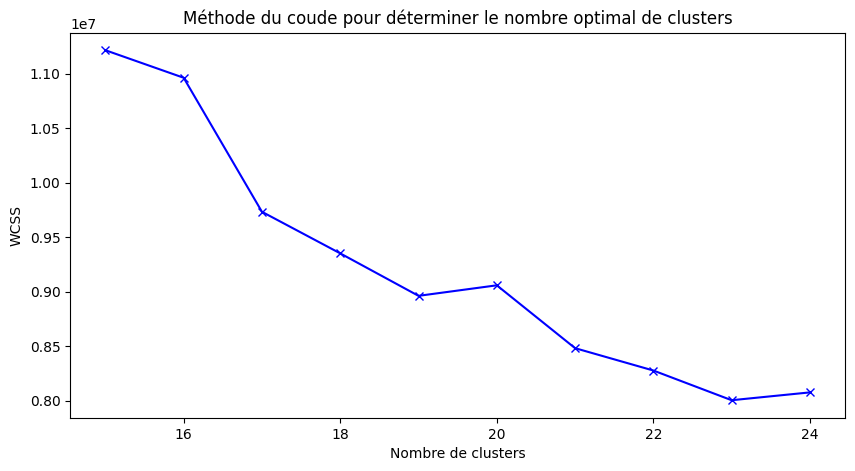

In [50]:
# Tracer le graphe de la méthode du coude
plt.figure(figsize=(10, 5))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()

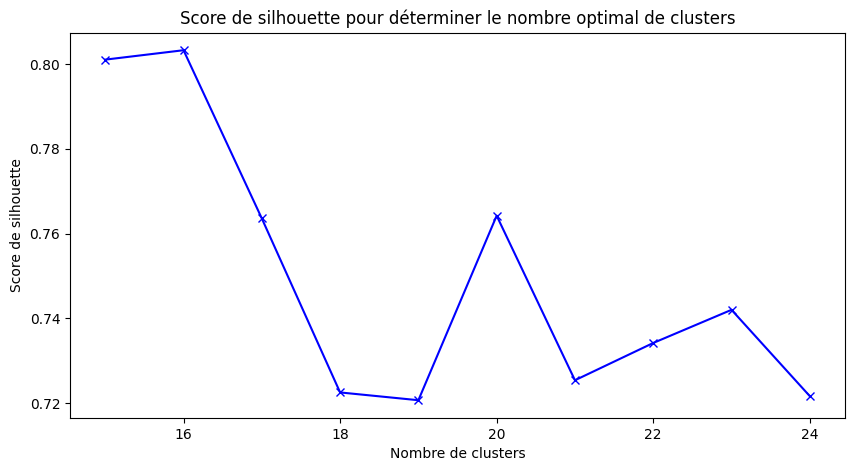

In [51]:
# Tracer le graphe du score de silhouette
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette pour déterminer le nombre optimal de clusters')
plt.show()


In [53]:
# Sélectionner le nombre optimal dans nootre cas, k=5)
kmeans = KMeans(k=17, featuresCol="scaled_features", seed=1)
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
model = pipeline.fit(user_df)

In [54]:
predictions = model.transform(user_df)
predictions.select("user_id", "prediction").show()

+---------+----------+
|  user_id|prediction|
+---------+----------+
|555563717|        11|
|534089759|         0|
|516013566|        10|
|526499638|        15|
|516381138|         0|
|552649574|         0|
|555600123|        11|
|522758840|         5|
|529162118|        11|
|540178955|        13|
|518437642|         0|
|554721305|        11|
|555013865|         5|
|522185879|        11|
|523570594|        11|
|551275697|        11|
|535165258|        11|
|542352108|         5|
|554393704|        11|
|555475998|        11|
+---------+----------+
only showing top 20 rows



In [55]:
predictions.groupBy("prediction").agg(count("prediction")).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|        13|           134443|
|         6|             5969|
|         3|              851|
|         5|           208063|
|        15|           538172|
|         9|            29438|
|         4|             4261|
|         7|              144|
|        10|            40855|
|        11|          7711013|
|        14|               67|
|         0|           899821|
|         1|                3|
|        12|                2|
|         8|               21|
|        16|                4|
|         2|                2|
+----------+-----------------+

